## Machine Learning 프로젝트 수행을 위한 코드 구조화

`(분류, 회귀 Task)`

- ML project를 위해서 사용하는 템플릿 코드를 만듭니다.

1. **필요한 라이브러리와 데이터를 불러옵니다.**


2. **EDA를 수행합니다.** 이 때 EDA의 목적은 풀어야하는 문제를 위해서 수행됩니다.


3. **전처리를 수행합니다.** 이 때 중요한건 **feature engineering**을 어떻게 하느냐 입니다.


4. **데이터 분할을 합니다.** 이 때 train data와 test data 간의 분포 차이가 없는지 확인합니다.


5. **학습을 진행합니다.** 어떤 모델을 사용하여 학습할지 정합니다. 성능이 잘 나오는 GBM을 추천합니다.


6. **hyper-parameter tuning을 수행합니다.** 원하는 목표 성능이 나올 때 까지 진행합니다. 검증 단계를 통해 지속적으로 **overfitting이 되지 않게 주의**하세요.


7. **최종 테스트를 진행합니다.** 데이터 분석 대회 포맷에 맞는 submission 파일을 만들어서 성능을 확인해보세요.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.3/365.3 KB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.6/210.6 KB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 3.9 MB/s eta 0:00:00


## 1. 라이브러리, 데이터 불러오기

In [3]:
# 데이터분석 4종 세트
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 모델들, 성능 평가
# (저는 일반적으로 정형데이터로 머신러닝 분석할 때는 이 2개 모델은 그냥 돌려봅니다. 특히 RF가 테스트하기 좋습니다.)
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from lightgbm.sklearn import LGBMClassifier
from lightgbm.sklearn import LGBMRegressor

# 상관관계 분석, VIF : 다중공선성 제거
from statsmodels.stats.outliers_influence import variance_inflation_factor

# KFold(CV), partial : optuna를 사용하기 위함
from sklearn.model_selection import KFold
from functools import partial

# hyper-parameter tuning을 위한 라이브러리, optuna
import optuna

In [4]:
# flag setting
data_reducing = False ## memory reducing technique
feature_reducing = False ## feature extraction (curse of dimensionality)

In [5]:
# 데이터를 불러옵니다.
base_path = "/content/drive/MyDrive/Colab Notebooks/data/Red Wine Quality/"
data = pd.read_csv(base_path + "winequality-red.csv")
data

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


## 2. EDA

- 데이터에서 찾아야 하는 기초적인 내용들을 확인합니다.


- class imbalance, target distribution, outlier, correlation을 확인합니다.

In [6]:
## On your Own
data[data.isnull().any(axis=1)]

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality


In [7]:
data.loc[:, data.columns[(data == 0).all()]]

""
0
1
2
3
4
...
1594
1595
1596
1597


In [8]:
data[(data == 0).all(axis=1)]

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality


In [9]:
data['quality'].value_counts()

5    681
6    638
7    199
4     53
8     18
3     10
Name: quality, dtype: int64

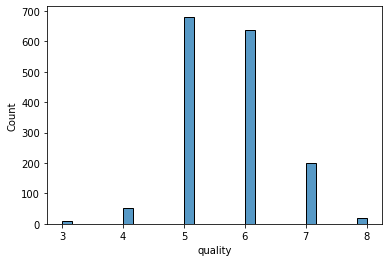

In [10]:
sns.histplot(data=data.quality)

In [11]:
data.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')

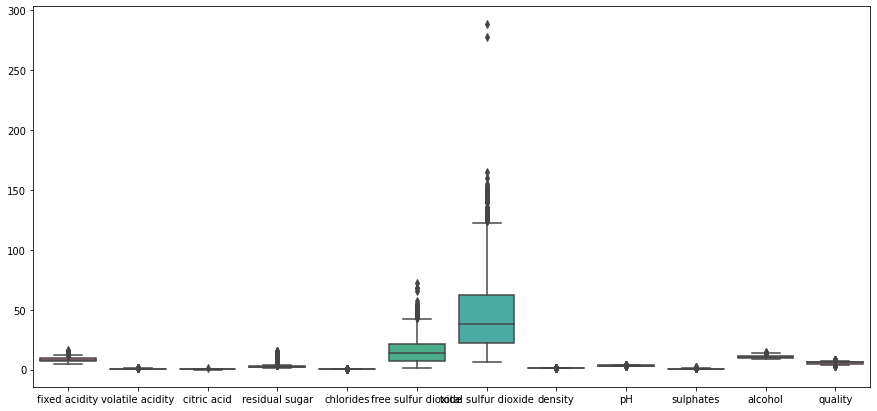

In [12]:
plt.figure(figsize=(15,7))
sns.boxplot(data=data)

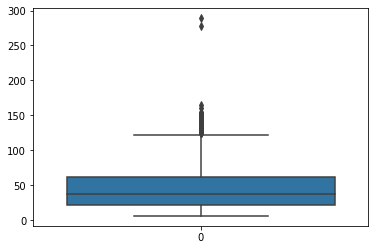

In [13]:
sns.boxplot(data=data['total sulfur dioxide'])

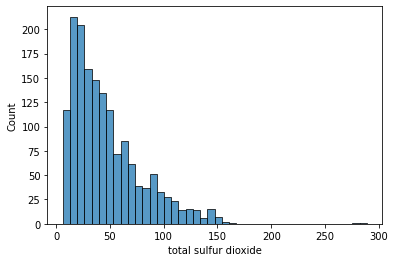

In [14]:
sns.histplot(data=data['total sulfur dioxide']) #200이상 제거

In [15]:
data = data.drop(data[data['total sulfur dioxide']>200].index, axis=0)

이런 식으로 여러가지 그래프를 그려가며, 데이터에 대한 인사이트를 얻습니다!

### 3. 전처리

#### 결측치 처리

In [16]:
# 결측치가 있는 column


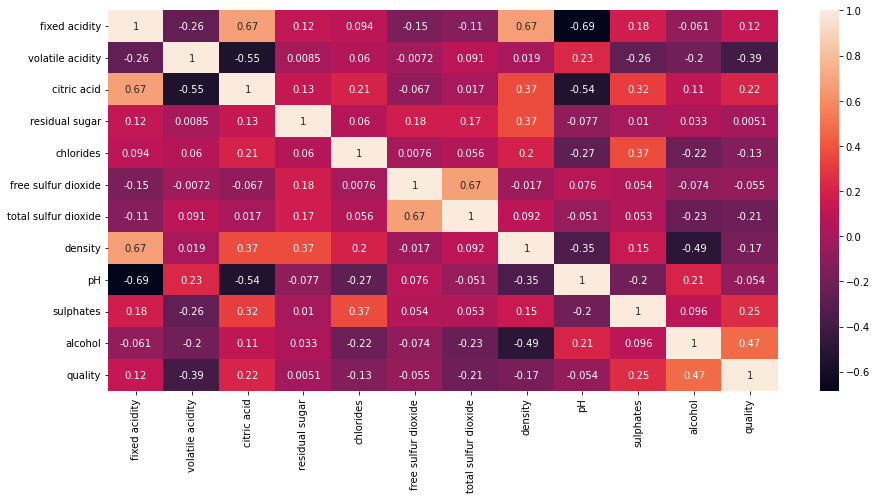

In [17]:
# 중복정보가 있는 column 제거하기 위해 상관계수를 확인해봅니다.
plt.figure(figsize=(15,7))
sns.heatmap(data.corr(), annot=True)

#### 다중공선성 처리

In [18]:
# 상관계수가 threshold(e.g. 0.69)를 넘기는 feature들을 제거합니다.
data = data.drop(columns=['fixed acidity'], axis=1)

#### Encoding Categorical Features

In [19]:
# dtype이 object인 변수들 처리.
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1597 entries, 0 to 1598
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   volatile acidity      1597 non-null   float64
 1   citric acid           1597 non-null   float64
 2   residual sugar        1597 non-null   float64
 3   chlorides             1597 non-null   float64
 4   free sulfur dioxide   1597 non-null   float64
 5   total sulfur dioxide  1597 non-null   float64
 6   density               1597 non-null   float64
 7   pH                    1597 non-null   float64
 8   sulphates             1597 non-null   float64
 9   alcohol               1597 non-null   float64
 10  quality               1597 non-null   int64  
dtypes: float64(10), int64(1)
memory usage: 149.7 KB


#### feature extraction

- 차원의 저주를 해결하거나, 데이터의 feature 조합을 이용하는 새로운 feature를 생성할 때, PCA를 사용합니다.

- 분석에 사용할 feature를 선택하는 과정도 포함합니다.

### 4. 학습 데이터 분할

In [20]:
# 첫번째 테스트용으로 사용하고, 실제 학습시에는 K-Fold CV를 사용합니다.
# train : test = 8 : 2
from sklearn.model_selection import train_test_split

y = data['quality']
X = data.drop(columns=['quality'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

In [21]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1277, 10) (1277,) (320, 10) (320,)


In [22]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

### 5. 학습 및 평가

In [23]:
# # 간단하게 LightGBM 테스트
# # 적당한 hyper-parameter 조합을 두었습니다. (항상 best는 아닙니다. 예시입니다.)

# param_grid = {
#     "max_bin" : 20,
#     "learning_rate" : 0.0025,
#     "objective" : "regression",
#     "boosting_type" : "gbdt",
#     "metric" : "mae",
#     "sub_feature" : 0.345,
#     "bagging_fraction" : 0.85,
#     "bagging_freq" : 40,
#     "num_leaves" : 512,
#     "min_data" : 500,
#     "min_hessian" : 0.05,
#     "verbose" : 2,
#     "feature_fraction_seed" : 2,
#     "bagging_seed" : 3
# }



In [77]:
print("\nFitting Random Forest...")
model = RandomForestClassifier(n_estimators=100, n_jobs=-1, max_depth=16)
model.fit(X_train, y_train)


Fitting Random Forest...


RandomForestClassifier(max_depth=16, n_jobs=-1)

In [30]:
print("\nFitting LGBM...")
model2 = LGBMClassifier()
model2.fit(X_train, y_train)


Fitting LGBM...


LGBMClassifier()

In [27]:
# metric은 그때마다 맞게 바꿔줘야 합니다.
from sklearn.metrics import accuracy_score
acc = accuracy_score

In [78]:
#RF
from sklearn.metrics import classification_report
print("Prediction")
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)


train_score = acc(y_train, pred_train)
test_score = acc(y_test, pred_test)

print(classification_report(y_train, pred_train))
print(classification_report(y_test, pred_test))

Prediction
              precision    recall  f1-score   support

           3       1.00      1.00      1.00         9
           4       1.00      1.00      1.00        43
           5       1.00      1.00      1.00       550
           6       1.00      1.00      1.00       502
           7       1.00      1.00      1.00       157
           8       1.00      1.00      1.00        16

    accuracy                           1.00      1277
   macro avg       1.00      1.00      1.00      1277
weighted avg       1.00      1.00      1.00      1277

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00        10
           5       0.71      0.82      0.76       131
           6       0.66      0.69      0.68       136
           7       0.62      0.40      0.48        40
           8       0.00      0.00      0.00         2

    accuracy                           0.68       320
   macro avg

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
#LGBM
print("Prediction")
pred_train2 = model2.predict(X_train)
pred_test2 = model2.predict(X_test)


train_score2 = acc(y_train, pred_train)
test_score2 = acc(y_test, pred_test)

print(classification_report(y_test, pred_test2))

### 6. Hyper-parameter Tuning

> GridSearchCV

In [73]:
# GridSearchCV를 이용하여 가장 좋은 성능을 가지는 모델을 찾아봅시다. (이것은 첫번째엔 선택입니다.)
# Lightgbm은 hyper-parameter의 영향을 많이 받기 때문에, 저는 보통 맨처음에 한번 정도는 가볍게 GCV를 해봅니다.
# 성능 향상이 별로 없다면, lightgbm으로 돌린 대략적인 성능이 이 정도라고 생각하면 됩니다.
# 만약 성능 향상이 크다면, 지금 데이터는 hyper-parameter tuning을 빡빡하게 하면 성능 향상이 많이 이끌어 낼 수 있습니다.

from sklearn.model_selection import GridSearchCV

param_grid = { 'n_estimators' : [10, 50, 100],
           'max_depth' : [6, 8, 10, 16],
           'min_samples_leaf' : [8, 12, 18],
           'min_samples_split' : [8, 16, 20]
            }

gcv = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1)

gcv.fit(X_train, y_train)
print("Best Estimator : ", gcv.best_estimator_)

Best Estimator :  RandomForestClassifier(max_depth=10, min_samples_leaf=8, min_samples_split=16,
                       n_jobs=-1)


In [74]:
print("Prediction with Best Estimator")
gcv_pred_train = gcv.predict(X_train)
gcv_pred_test = gcv.predict(X_test)

gcv_train_score = acc(y_train, gcv_pred_train)
gcv_test_score = acc(y_test, gcv_pred_test)

print("Train Score : %.4f" % gcv_train_score)
print("Test Score : %.4f" % gcv_test_score)

Prediction with Best Estimator
Train Score : 0.7760
Test Score : 0.6219


In [ ]:
print("Performance Gain") # 이걸로 성능 향상 확인.
print("in train : ", (train_score - gcv_train_score))
print("in test : ", (test_score - gcv_test_score))

> optuna를 사용해봅시다 !

In [ ]:
# For Regression

def optimizer(trial, X, y, K):
    # 조절할 hyper-parameter 조합을 적어줍니다.
    n_estimators = trial.suggest_int("n_estimators", 50, 200)
    max_depth = trial.suggest_int("max_depth", 8, 30)
    
    
    # 원하는 모델을 지정합니다, optuna는 시간이 오래걸리기 때문에 저는 보통 RF로 일단 테스트를 해본 뒤에 LGBM을 사용합니다.
    model = LGBMClassifier(n_estimators=n_estimators,
                                  max_depth=max_depth,
                                  n_jobs=-1,
                                  random_state=0xC0FFEE)
    
    
    # K-Fold Cross validation을 구현합니다.
    folds = KFold(n_splits=K)
    scores = []
    
    for train_idx, val_idx in folds.split(X, y):
        X_train = X.iloc[train_idx, :]
        y_train = y.iloc[train_idx]
        
        X_val = X.iloc[val_idx, :]
        y_val = y.iloc[val_idx]
        
        model.fit(X_train, y_train)
        preds = model.predict(X_val)
        score = acc(y_val, preds)
        scores.append(score)
    
    
    # K-Fold의 평균 loss값을 돌려줍니다.
    return np.mean(scores)

In [ ]:
K = 5# Kfold 수
opt_func = partial(optimizer, X=X_train, y=y_train, K=K)

study = optuna.create_study(direction="maximize") # 최소/최대 어느 방향의 최적값을 구할 건지.
study.optimize(opt_func, n_trials=30)

In [ ]:
# optuna가 시도했던 모든 실험 관련 데이터
study.trials_dataframe()

In [ ]:
print("Best Score: %.4f" % study.best_value) # best score 출력
print("Best params: ", study.best_trial.params) # best score일 때의 하이퍼파라미터들

In [ ]:
# 실험 기록 시각화
optuna.visualization.plot_optimization_history(study)

In [ ]:
# hyper-parameter들의 중요도
optuna.visualization.plot_param_importances(study)